In [1]:
import os
import mne
import numpy as np
import sys
import pandas as pd
import logging
from enum import Enum
from typing import Optional, Generator
from collections import namedtuple
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt
from deepmeg.params import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions, WaveForms
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.preprocessing import BasicPreprocessor
from utils.storage import DLStorageIterator, STAGE


EOI = 103 # Id of the Event of Interest

SpatialParameters = namedtuple('SpatialParameters', 'patterns filters')
TemporalParameters = namedtuple('TemporalParameters', 'franges finputs foutputs fresponces')
ComponentsOrder = namedtuple('ComponentsOrder', 'l2 compwise_loss weight output_corr weight_corr')
Predictions = namedtuple('Predictions', 'y_p y_true')
WaveForms = namedtuple('WaveForms', 'evoked induced times tcs')

logging.basicConfig(
    format='%(asctime)s %(levelname)s:\t%(message)s',
    filename='../logs/reader.log',
    encoding='utf-8',
    level=logging.DEBUG
)


2023-01-14 17:40:27.267645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 17:40:27.388934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 17:40:27.388956: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-14 17:40:28.118333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
import os

def create_dir_once(path):
    def decorator(func):
        def wrapper(*args, **kwargs):
            if not os.path.exists(path):
                func(*args, **kwargs)
        return wrapper
    return decorator


@create_dir_once
def create_dir(path):
    os.makedirs(path)


create_dir('../logs')


logging.basicConfig(
    format='%(asctime)s %(levelname)s:\t%(message)s', datefmt='%Y-%m-%d %H:%M:%S',
    filename='../logs/reader.log',
    encoding='utf-8',
    level=logging.DEBUG
)


In [3]:
import mneflow
import tensorflow as tf
import scipy.signal as sl

from deepmeg.params import compute_patterns, compute_temporal_parameters, compute_waveforms


In [4]:
# create iterator for data samples
s = DLStorageIterator('../DATA', 'def_name')
# get first data sample
next(s)
# preprocess data sample
pretest = BasicPreprocessor(103, 200, 2)(s.get_data(STAGE.PRETEST))


Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PreTest/PreTest_epochs_sel.fif ...


/home/user/Projects/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../DATA/subj02/PreTest/PreTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
890 matching events found
No baseline correction applied
0 projection items activated


In [15]:
def balance(X: np.ndarray, Y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Balance the dataset by taking the same number of samples for each class.

    Args:
        X: numpy array of shape (n_samples, n_features)
        Y: numpy array of shape (n_samples, )

    Returns:
        X_balanced: numpy array of shape (n_samples, n_features)
        Y_balanced: numpy array of shape (n_samples, )
    """
    classes, classes_samples = np.unique(Y, return_counts=True)
    smallest_class = classes[np.argsort(classes_samples)][0]
    samples = classes_samples.min()
    X_list, Y_list = list(), list()
    stat = {class_: 0 for class_ in classes}

    for x, y in zip(X, Y):
        if y != smallest_class and stat[y] >= samples:
            continue
        else:
            Y_list.append(y)
            X_list.append(x)
            stat[y] += 1

    return np.array(X_list), np.array(Y_list)


Xb, Yb = balance(X, Y)

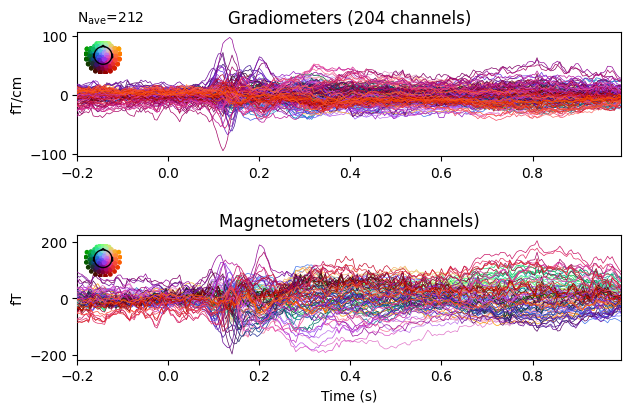

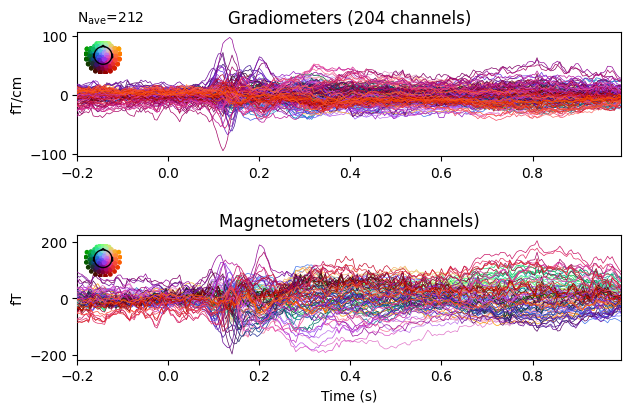

In [5]:
pretest.epochs.average().plot()

In [5]:
X = pretest.epochs.get_data()
Y = pretest.clusters

In [ ]:
from utils.preprocessing import Preprocessed

"""
This is a module for defining triplets.
"""


def define_triplet(proc: Preprocessed, target: str) -> np.ndarray:
    """
    This function defines triplet for each cluster.
    :param proc: Preprocessed object
    :param target: str
    :return: np.ndarray
    """
    for q, o in zip(
        list(map(
            BasicPreprocessor.define_quarter,
            proc.coordinates >= 0
        )),
        proc.session_info[target].to_list()
    ):
        print('ok')
        res = list()
        if o == 0:
            if q == 0:
                res.append(0)
            elif q == 2:
                res.append(2)
            else:
                res.append(1)
        else:
            res.append(1)

    # assert len(res) == len(proc.clusters)

    return np.array(res)



triplets = define_triplet(pretest, 'Outcome')

In [19]:
triplets

array([1])

In [17]:
triplets.shape

(1,)

In [5]:
X = epochs.get_data()
Y = clusters

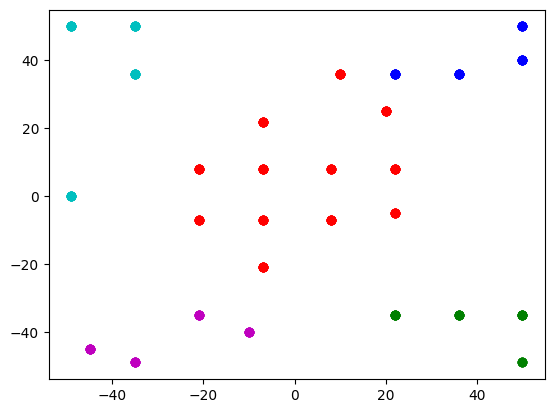

In [20]:
# plot the clusters
for coord, cluster in zip(pretest.coordinates, pretest.clusters):
    match cluster:
        case 0.:
            color = 'r'
        case 1.:
            color = 'g'
        case 2.:
            color = 'b'
        case 3.:
            color = 'c'
        case 4.:
            color ='m'

    plt.plot(*coord, 'o', color=color)
plt.show()



In [ ]:
fig = epochs[np.where(clusters == 0)[0]].apply_baseline().average().plot()
fig = epochs[np.where(clusters == 1)[0]].apply_baseline().average().plot()
fig = epochs[np.where(clusters == 2)[0]].apply_baseline().average().plot()
fig = epochs[np.where(clusters == 3)[0]].apply_baseline().average().plot()
fig = epochs[np.where(clusters == 4)[0]].apply_baseline().average().plot()

In [6]:

s = BasicStorageManager('../DATA')
_, epochs_pre, _, _, clusters_pre = next(BasicPreprocessor(s)(stage=STAGE.PRETEST))
_, epochs_post, _, _, clusters_post = next(BasicPreprocessor(s)(stage=STAGE.POSTTEST))

Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PreTest/PreTest_epochs_sel.fif ...


/tmp/ipykernel_1110692/2206014946.py:56: RuntimeWarning: This filename (../DATA/subj02/PreTest/PreTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
890 matching events found
No baseline correction applied
0 projection items activated
Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PostTest/PostTest_epochs_sel.fif ...


/tmp/ipykernel_1110692/2206014946.py:56: RuntimeWarning: This filename (../DATA/subj02/PostTest/PostTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
889 matching events found
No baseline correction applied
0 projection items activated


In [5]:
epochs_pre.info

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers, 1 misc, 3 Stimulus
 custom_ref_applied: False
 description: vectorview system
 dev_head_t: MEG device -> head transform
 dig: 917 items (3 Cardinal, 5 HPI, 909 Extra)
 events: 1 item (list)
 experimenter: MEG guest (megguest)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 100.0 Hz
 meas_date: 2022-07-18 08:34:46 UTC
 meas_id: 4 items (dict)
 nchan: 310
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: visual
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>

In [26]:
epochs_post.info

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0122, MEG0123, MEG0132, MEG0133, MEG0143, ...
 chs: 204 Gradiometers
 custom_ref_applied: False
 description: vectorview system
 dev_head_t: MEG device -> head transform
 dig: 917 items (3 Cardinal, 5 HPI, 909 Extra)
 events: 1 item (list)
 experimenter: MEG guest (megguest)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 100.0 Hz
 meas_date: 2022-07-18 09:29:39 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: visual
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>

In [20]:
mne.concatenate_epochs([epochs_pre, epochs_post])

ValueError: epochs[1].info['dev_head_t'] differs. The instances probably come from different runs, and are therefore associated with different head positions. Manually change info['dev_head_t'] to avoid this message but beware that this means the MEG sensors will not be properly spatially aligned. See mne.preprocessing.maxwell_filter to realign the runs to a common head position.

In [7]:
X = np.concatenate([epochs_pre.pick_types(meg='grad').get_data(), epochs_post.pick_types(meg='grad').get_data()])
Y = np.concatenate([clusters_pre, clusters_post])

In [5]:
import numpy as np

grades = np.array([
    4, 5, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 5, 5, 3, 5, 4, 5, 5, 4, 5, 4, 4, 4, 5, 5, 5, 5
])

(grades - 3).mean()

1.3333333333333333

In [8]:
#Specify import options
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=200,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 40),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords((X, Y), **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X: (424, 204, 240) targets: (424,)
(424,)
Preprocessing:
Scaling to interval 0.0 - 40.0
n: 424
Splitting into: 6 folds x 70
Preprocessed: (424, 1, 200, 204) (424, 1) folds: 6 x 70
Prepocessed sample shape: (1, 200, 204)
Target shape actual/metadata:  (5,) (5,)
Saving TFRecord# 0


2022-12-07 00:13:24.408588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 00:13:24.408632: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 00:13:24.408670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2022-12-07 00:13:24.424193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
dataset.train.element_spec

(TensorSpec(shape=(None, 1, 200, 204), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.int64, name=None))

In [13]:
dataset.test.element_spec


(TensorSpec(shape=(None, 1, 200, 204), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.int64, name=None))

In [19]:
# specify model parameters
lf_params = dict(
    n_latent=32, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.elu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-1
)

model = SimpleNet(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 200, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 200, 32)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 200, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 40, 32)
Input shape: (1, 200, 204)
y_pred: (None, 5)
Initialization complete!


In [2]:
import os

path = '/a/b/c/d/e/f/g'

os.path.base

'..'

In [20]:
model.train(n_epochs=25, eval_step=100, early_stopping=3)
model.plot_hist()

Epoch 1/25
100/100 - 4s - loss: 1.3901 - cat_ACC: 0.4047 - val_loss: 1.3975 - val_cat_ACC: 0.4386 - 4s/epoch - 42ms/step
Epoch 2/25
100/100 - 3s - loss: 0.7013 - cat_ACC: 0.7653 - val_loss: 1.5907 - val_cat_ACC: 0.3860 - 3s/epoch - 29ms/step
Epoch 3/25
100/100 - 3s - loss: 0.2303 - cat_ACC: 0.9427 - val_loss: 1.9903 - val_cat_ACC: 0.4386 - 3s/epoch - 27ms/step
Epoch 4/25
100/100 - 3s - loss: 0.0813 - cat_ACC: 0.9873 - val_loss: 2.3364 - val_cat_ACC: 0.4035 - 3s/epoch - 26ms/step
2/2 [==============================] - 0s 6ms/step
single_fold with 1 fold(s) completed. 

              Loss: 1.3975 +/- 0.0000.
              Metric: 0.4386 +/- 0.0000
Test performance:
Updating log: test loss: 1.3436 test metric: 0.4429


In [21]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.44285714626312256

In [13]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)


Maximum r_spear: 0.7327845231047831
Maximum r_spear: 0.806962245609611
Maximum r_spear: 0.3680507246826892
Maximum r_spear: 0.640064681104074
Maximum r_spear: 0.3860705832485112


/tmp/ipykernel_3590094/2453767372.py:181: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  self.fake_evoked.plot_topomap(
/tmp/ipykernel_3590094/2453767372.py:181: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  self.fake_evoked.plot_topomap(


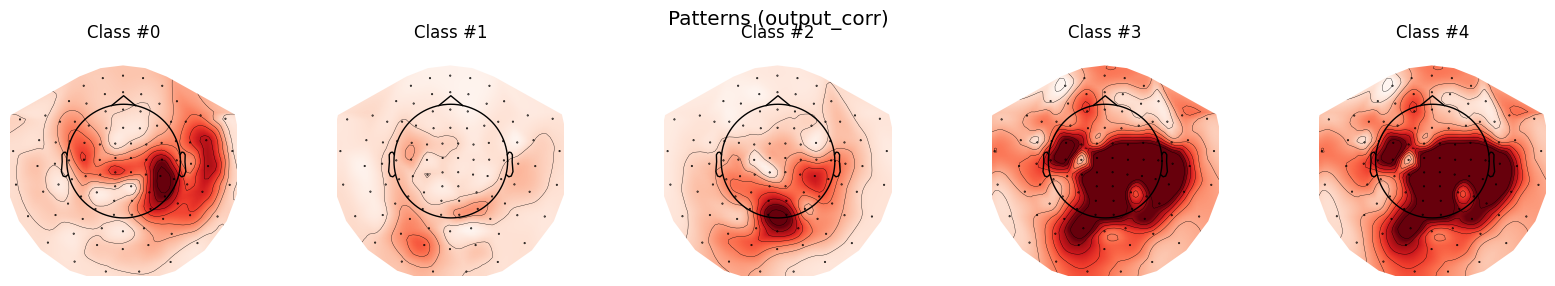

In [14]:
f1 = model.plot_patterns(info=epochs_pre.info, sorting='output_corr')

Maximum spearman r: 0.7327845231047831
Maximum spearman r: 0.806962245609611
Maximum spearman r: 0.3680507246826892
Maximum spearman r: 0.640064681104074
Maximum spearman r: 0.3860705832485112


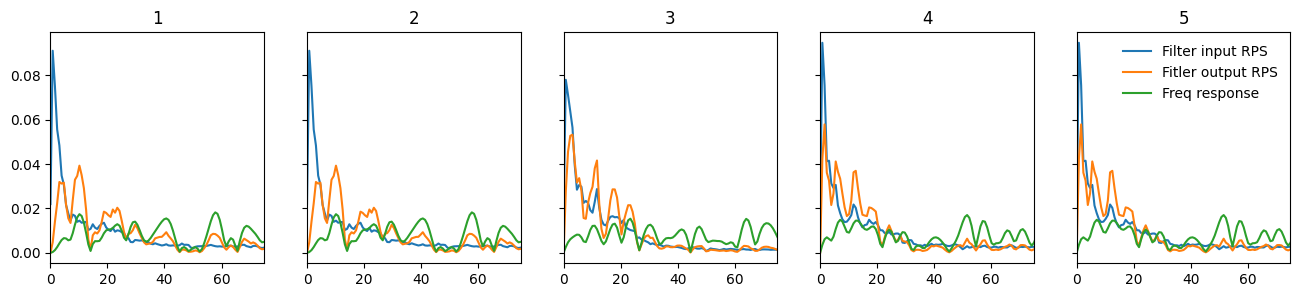

In [15]:
f2 = model.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=['1', '2', '3', '4', '5'])

In [16]:
from deepmeg.params import SpatialParameters,\
    TemporalParameters,\
    ComponentsOrder,\
    Predictions,\
    WaveForms,\
    compute_morlet_cwt,\
    compute_waveforms,\
    compute_temporal_parameters,\
    get_order

In [22]:
%matplotlib qt

train_paths = '../TFR/mne_sample_epochs_test_0.tfrecord'

# compute_patterns(model, train_paths)
model.compute_patterns(train_paths)
nt = model.dataset.h_params['n_t']
time_courses = np.squeeze(model.lat_tcs.reshape([model.specs['n_latent'], -1, nt]))
times = (1 / float(model.dataset.h_params['fs'])) *\
    np.arange(model.dataset.h_params['n_t'])
patterns = model.patterns.copy()
model.compute_patterns(train_paths, output='filters')
filters = model.patterns.copy()
franges, finputs, foutputs, fresponces = compute_temporal_parameters(model)
induced, times, time_courses = compute_waveforms(model)

wf = WaveForms(time_courses.mean(1), induced, times, time_courses)
sp = SpatialParameters(patterns, filters)
tp = TemporalParameters(franges, finputs, foutputs, fresponces)
srp = ComponentsOrder(
    get_order(*model._sorting('l2')),
    get_order(*model._sorting('compwise_loss')),
    get_order(*model._sorting('weight')),
    get_order(*model._sorting('output_corr')),
    get_order(*model._sorting('weight_corr')),
)


Maximum weight: 0.08416151
Maximum weight: 0.089091584
Maximum weight: 0.08326398
Maximum weight: 0.094420776
Maximum weight: 0.09100167
Maximum r_spear: 0.8440876266686241
Maximum r_spear: 0.6561697401339186
Maximum r_spear: 0.5141181303188207
Maximum r_spear: 0.5006096424767745
Maximum r_spear: 0.34292423170700204
Maximum spearman r: 0.8440876266686241
Maximum spearman r: 0.6561697401339186
Maximum spearman r: 0.5141181303188207
Maximum spearman r: 0.5006096424767745
Maximum spearman r: 0.34292423170700204


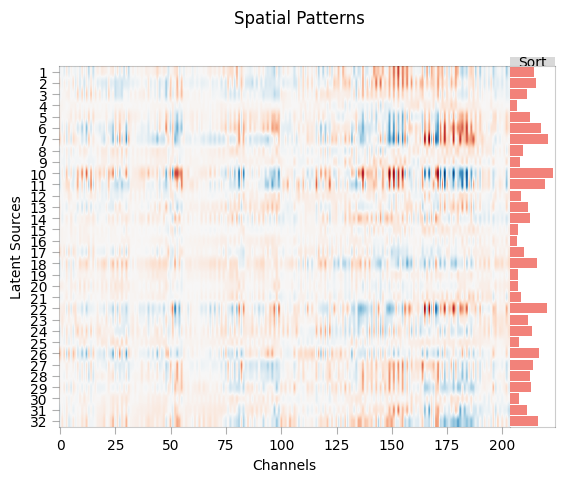

/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/viz.py:30: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  return patterns.plot_topomap(
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/viz.py:30: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  return patterns.plot_topomap(
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/viz.py:30: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  return patterns.plot_topomap(
/home/user/Projects/NeuralGeometry/venv/lib/python3.10/site-packages/deepmeg/viz.py:30: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  return patterns.plot_topomap(
/home/user/Projects/NeuralGeometry/venv/lib/python3.

In [23]:
from deepmeg.viz import plot_spatial_weights

plot_spatial_weights(
    sp,
    tp,
    wf,
    epochs_pre.info,
    summarize='sumabs',
    logscale=False
)

In [7]:
import re
inp_str = "subj100"


print("Original string : " + inp_str)

num = int(re.findall(r'\d+', inp_str)[0])

print(num)

Original string : subj100
100


2022-12-16 17:36:59.497539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 17:36:59.721081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-16 17:36:59.721109: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-16 17:37:00.588763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
outputs

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [1.        ]], dtype=float32)>